<a href="https://colab.research.google.com/github/abrarelidrisi/MRI-Segmentation/blob/main/Trial_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

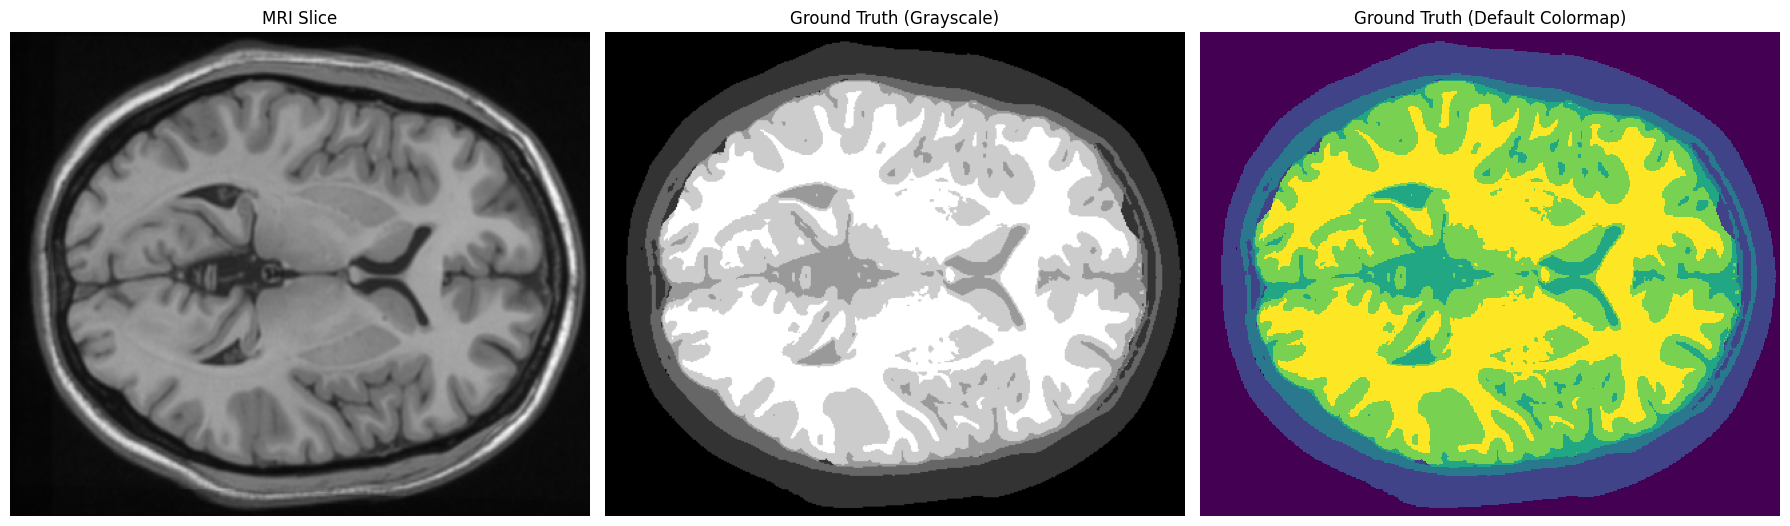

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.io import loadmat
import sys

# Load data
data = loadmat('Brain.mat')
T1 = data['T1']
label = data['label']
import matplotlib.pyplot as plt

# Select a single slice (e.g., the first slice)
slice_data = T1[..., 0]
ground_truth = label[..., 0]

# Creating a figure with 1 row and 3 columns
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Display the MRI slice (grayscale)
ax[0].imshow(slice_data, cmap='gray')
ax[0].set_title("MRI Slice")
ax[0].axis('off')  # Turn off axis for cleaner display

# Display the ground truth as-is (grayscale)
ax[1].imshow(ground_truth, cmap='gray')
ax[1].set_title("Ground Truth (Grayscale)")
ax[1].axis('off')

# Display the ground truth with the default colormap
ax[2].imshow(ground_truth, interpolation='none', vmin=0, vmax=5)  # Default colormap
ax[2].set_title("Ground Truth (Default Colormap)")
ax[2].axis('off')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

In [3]:
# Inspect the range of pixel intensities in the slice
print(f"Slice intensity range: Min = {np.min(slice_data)}, Max = {np.max(slice_data)}")
print(f"Ground truth range: Min = {np.min(ground_truth)}, Max = {np.max(ground_truth)}")

# Check unique labels in the ground truth
unique_labels = np.unique(ground_truth)
print(f"Unique labels in the ground truth: {unique_labels}")

Slice intensity range: Min = 958.6986694335938, Max = 491434.28125
Ground truth range: Min = 0, Max = 5
Unique labels in the ground truth: [0 1 2 3 4 5]


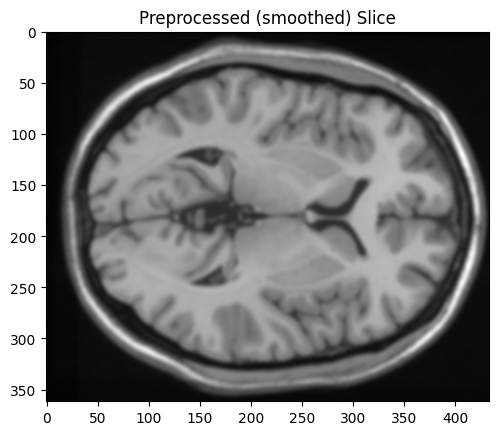

In [4]:
# Normalize the slice
slice_normalized = (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data))

# Apply Gaussian smoothing
slice_smoothed = cv2.GaussianBlur(slice_normalized, (5, 5), 5)

# Visualize the preprocessed slice
plt.imshow(slice_smoothed, cmap='gray')
plt.title("Preprocessed (smoothed) Slice")
plt.show()


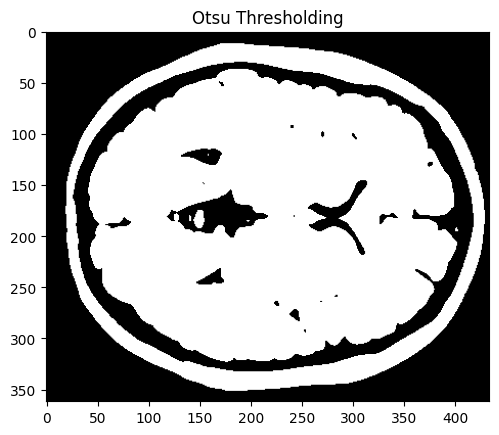

In [8]:
# Apply Otsu's thresholding
_, thresholded = cv2.threshold((slice_smoothed * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Visualize thresholded result
plt.imshow(thresholded, cmap='gray')
plt.title("Otsu Thresholding")
plt.show()

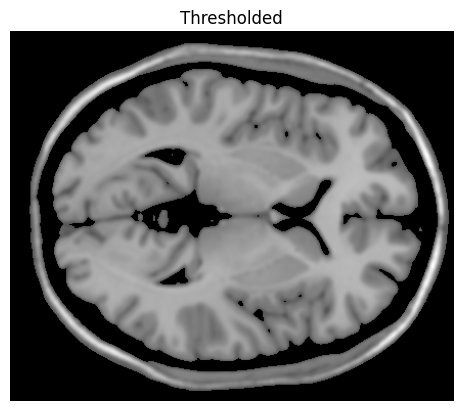

In [10]:
thresholded_img = thresholded * slice_smoothed
plt.imshow(thresholded_img, cmap='gray')
plt.axis('off')
plt.title('Thresholded')
plt.show()

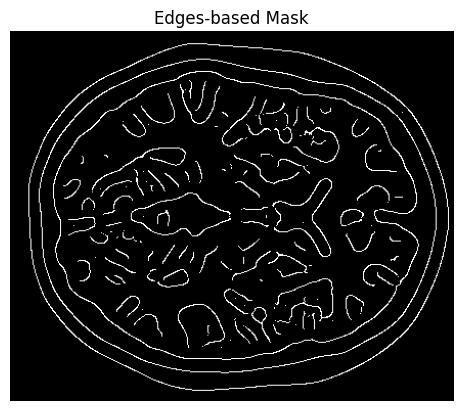

In [12]:
from skimage.morphology import remove_small_objects, remove_small_holes, binary_dilation
from skimage.feature import canny
import scipy.ndimage as ndi

edges = canny(thresholded_img, sigma=5)

# Plot the edges
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.title('Edges-based Mask')
plt.show()

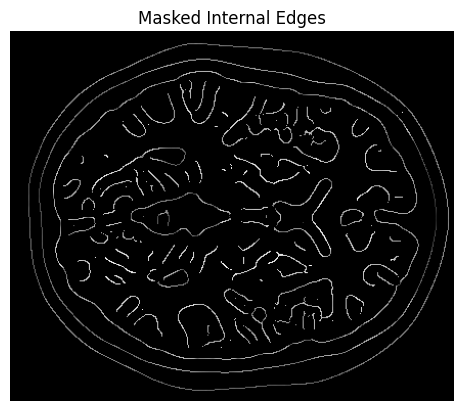

In [13]:
img_thresholded = slice_normalized * edges
plt.imshow(img_thresholded, cmap = "grey")
plt.axis('off')
plt.title('Masked Internal Edges')
plt.show()

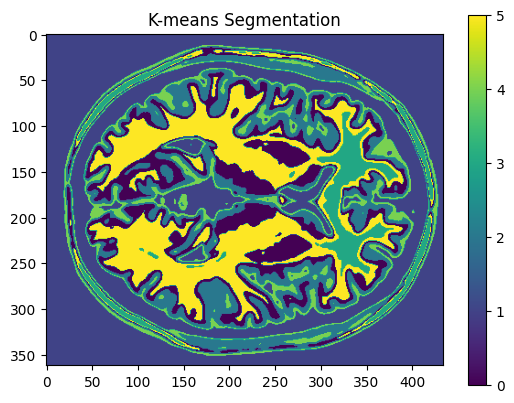

In [19]:
from sklearn.cluster import KMeans

# Flatten and normalize the slice for clustering
slice_flat = thresholded_img.flatten().reshape(-1, 1)

# Apply K-means clustering
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(slice_flat)

# Reshape the labels back to the original slice shape
kmeans_segmented = kmeans_labels.reshape(slice_smoothed.shape)

# Visualize the K-means segmentation result
plt.imshow(kmeans_segmented)
plt.title("K-means Segmentation")
plt.colorbar()
plt.show()

In [20]:
def dice_coefficient(pred, truth):
    pred = pred > 0  # Ensure binary format
    truth = truth > 0  # Ensure binary format
    intersection = np.sum(pred * truth)
    return 2 * intersection / (np.sum(pred) + np.sum(truth))

dice_score = dice_coefficient(kmeans_segmented, ground_truth)
print(f"Dice Coefficient: {dice_score:.3f}")

Dice Coefficient: 0.742


In [21]:
def jaccard_index(pred, truth):
    pred = pred > 0
    truth = truth > 0
    intersection = np.sum(pred * truth)
    union = np.sum(pred + truth) - intersection
    return intersection / union
jaccard_score = jaccard_index(kmeans_segmented, ground_truth)
print(f"Jaccard Index: {jaccard_score:.3f}")

Jaccard Index: 1.434


In [22]:
def pixel_accuracy(pred, truth):

    pred = pred > 0  # Ensure binary format
    truth = truth > 0  # Ensure binary format

    correct = np.sum(pred == truth)  # Count matching pixels
    total = truth.size  # Total number of pixels
    return correct / total

accuracy_score = pixel_accuracy(kmeans_segmented, ground_truth)
print(f"Pixel Accuracy: {accuracy_score:.3f}")

Pixel Accuracy: 0.589


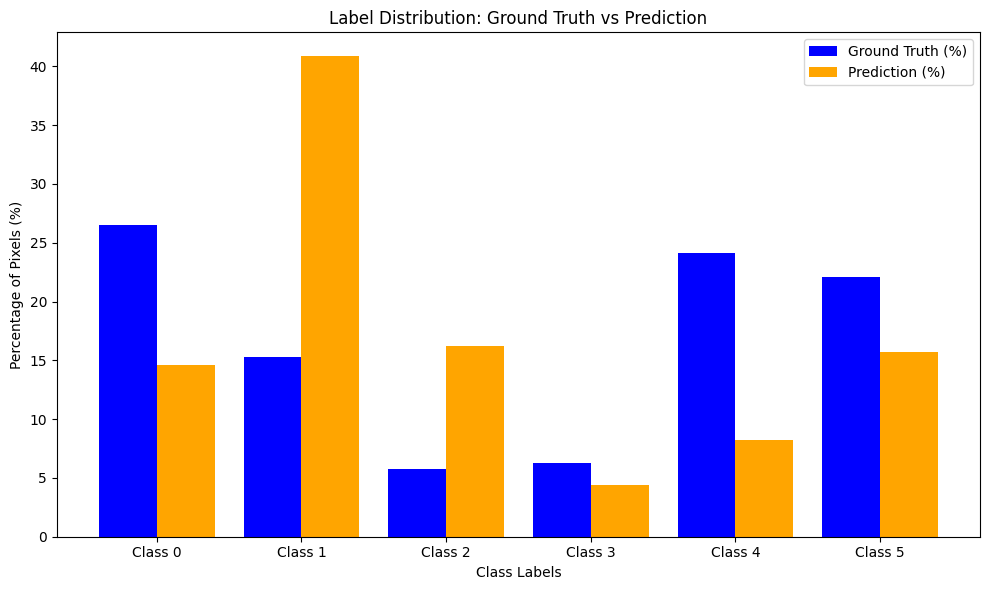

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def compare_label_distributions(ground_truth, prediction, num_classes):

    # Count label occurrences in ground truth
    gt_labels, gt_counts = np.unique(ground_truth, return_counts=True)
    gt_distribution = np.zeros(num_classes)
    gt_distribution[gt_labels] = gt_counts

    # Count label occurrences in prediction
    pred_labels, pred_counts = np.unique(prediction, return_counts=True)
    pred_distribution = np.zeros(num_classes)
    pred_distribution[pred_labels] = pred_counts

    # Normalize to percentage if needed
    gt_percentage = (gt_distribution / np.sum(gt_distribution)) * 100
    pred_percentage = (pred_distribution / np.sum(pred_distribution)) * 100

    # Plot the distributions
    labels = [f"Class {i}" for i in range(num_classes)]
    x = np.arange(num_classes)

    plt.figure(figsize=(10, 6))

    # Bar plot
    plt.bar(x - 0.2, gt_percentage, width=0.4, label='Ground Truth (%)', color='blue')
    plt.bar(x + 0.2, pred_percentage, width=0.4, label='Prediction (%)', color='orange')

    # Add labels, legend, and title
    plt.xticks(x, labels)
    plt.xlabel("Class Labels")
    plt.ylabel("Percentage of Pixels (%)")
    plt.title("Label Distribution: Ground Truth vs Prediction")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
num_classes = 6  # Number of classes in your dataset
compare_label_distributions(ground_truth, kmeans_segmented, num_classes)